# refellips demo: Solid/Liquid
This demo presents an example use case for fitting multi-wavelength single-angle ellipsometry data for solid-liquid systems with refellips.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

/Users/hayden/Documents/GitHub/refellips/demos/refnx/reflect/reflect_model.py:184: UserWarning: Can't use the C abeles backend
  warnings.warn("Can't use the C abeles backend")
/Users/hayden/Documents/GitHub/refellips/demos/refnx/reflect/reflect_model.py:196: UserWarning: Using the SLOW reflectivity calculation.
  warnings.warn("Using the SLOW reflectivity calculation.")


In [3]:
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import RI

### Import data

In [4]:
dname = 'WVASE_example_2nmSiO2_100nmPNIPAM_MultiWavelength_Water.dat'
data = DataSE(data=dname)

### Build model

In [6]:
from refnx.reflect import Linear, Erf

si     = RI('../refellips/materials/silicon.csv')
sio2   = RI('../refellips/materials/silica.csv')
PNIPAM = RI('../refellips/materials/pnipam.csv')
h2o    = RI('../refellips/materials/water.csv')

PNIPAM_layer = PNIPAM(1000)
PNIPAM_layer.thick.setp(vary=True, bounds=(100,1500))
PNIPAM_layer.vfsolv.setp(vary=True, value=0.8, bounds=(0.1,1))
PNIPAM_layer.rough.setp(vary=True, value=100, bounds=(50,300))
PNIPAM_layer.interfaces = Erf()

struc = h2o() | PNIPAM_layer | sio2(20) | si()
struc.contract = 2
struc.solvent= h2o

model = ReflectModelSE(struc)
model.DeltaOffset.setp(value=0, vary=True, bounds=(-10,10))

# Fitting experimental data

### Model & data pre fit

[Text(0, 0.5, 'Delta')]

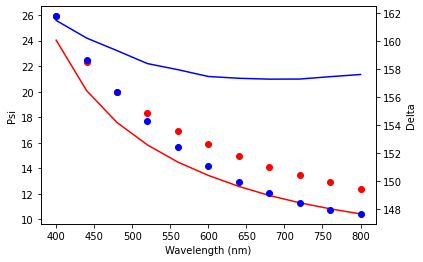

In [7]:
fig, ax = plt.subplots()
axt = ax.twinx()

wavelength_aois = np.c_[data.wavelength, data.aoi]
psi, delta = model(wavelength_aois)

ax.scatter(data.wavelength, data.psi, color='r')
axt.scatter(data.wavelength, data.delta, color='b')

ax.plot(data.wavelength, psi, color='r')
axt.plot(data.wavelength, delta, color='b')

ax.set(ylabel='Psi', xlabel='Wavelength (nm)')
axt.set(ylabel='Delta')

In [8]:
objective = ObjectiveSE(model, data)

In [9]:
fitter = CurveFitter(objective)
fitter.fit(method='least_squares');

### Model & data post fit

[Text(0, 0.5, 'Delta')]

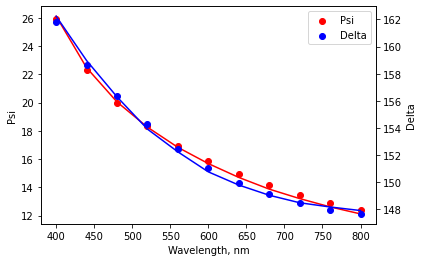

In [10]:
fig, ax = plt.subplots()
axt = ax.twinx()

wavelength_aois = np.c_[data.wavelength, data.aoi]
psi, delta = model(wavelength_aois)

p = ax.scatter(data.wavelength, data.psi, color='r')
d = axt.scatter(data.wavelength, data.delta, color='b')

ax.plot(data.wavelength, psi, color='r')
axt.plot(data.wavelength, delta, color='b')

ax.legend(handles=[p,d], labels=['Psi', 'Delta'])
ax.set(ylabel='Psi', xlabel='Wavelength, nm')
axt.set(ylabel='Delta')

### Refractive index profile

[Text(0, 0.5, 'Refractive index'), Text(0.5, 0, 'Distance from substrate (Å)')]

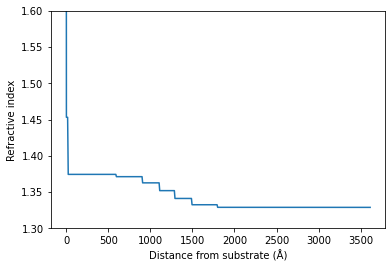

In [11]:
fig, ax = plt.subplots()
struc.reverse_structure = True
ax.plot(*struc.sld_profile())
struc.reverse_structure = False
ax.set_ybound(1.3,1.6)
ax.set(ylabel='Refractive index', xlabel='Distance from substrate (Å)')

In [12]:
for x in fitter.objective.model.parameters:
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=-4.12545 +/- 0.446, bounds=[-10.0, 10.0]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=1184.09 +/- 15.6 , bounds=[100.0, 1500.0]>
<Parameter:  ' - rough'   , value=299.835  +/- 6.2 , bounds=[50.0, 300.0]>
<Parameter:' - volfrac solvent', value=0.728086 +/- 0.00514, bounds=[0.1, 1.0]>
___________________________________________